# PvP playout analysis

In [25]:
import sys
import os

project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Measure win rates

In [6]:

from catan.core.game import Game
from catan.core.models.player import Color, RandomPlayer


def playout(players):
    game = Game(players=players)
    game.play()
    
    return game.state.num_turns

def n_playout_steps(players, n_playouts):
    return [playout(players) for _ in range(n_playouts)]

    
n_games = 500
steps_by_player = [
    n_playout_steps([RandomPlayer(color=Color.BLUE), ], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.RED)], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.RED), RandomPlayer(color=Color.ORANGE)], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.WHITE), RandomPlayer(color=Color.RED), RandomPlayer(color=Color.ORANGE)], n_games),
]


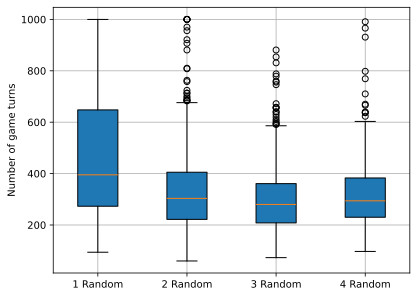

In [103]:
from matplotlib import pyplot as plt


labels = ['1 Random', '2 Random', '3 Random', '4 Random']

fig, ax = plt.subplots()
ax.set_ylabel('Number of game turns')

bplot = ax.boxplot(
    steps_by_player,
    tick_labels=labels,
    patch_artist=True
)
ax.grid(visible=True)


plt.show()

## MCTS bots

In [33]:
from catan.bots.mcts_bot import MCTSBot


game = Game(
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(
            color=Color.BLUE,
            n_simulations=50,
            debug=True
        ),
    ]
)
game.play()

[<catan.bots.mcts.MCTSNode object at 0x1313c6690>, <catan.bots.mcts.MCTSNode object at 0x1312e5410>, <catan.bots.mcts.MCTSNode object at 0x131f8b310>, <catan.bots.mcts.MCTSNode object at 0x131f8b450>, <catan.bots.mcts.MCTSNode object at 0x131f8bb90>, <catan.bots.mcts.MCTSNode object at 0x1312bd7d0>, <catan.bots.mcts.MCTSNode object at 0x131874550>, <catan.bots.mcts.MCTSNode object at 0x13148ccd0>, <catan.bots.mcts.MCTSNode object at 0x1314695d0>, <catan.bots.mcts.MCTSNode object at 0x131f89650>, <catan.bots.mcts.MCTSNode object at 0x1312bc190>, <catan.bots.mcts.MCTSNode object at 0x130be3bd0>, <catan.bots.mcts.MCTSNode object at 0x131393e10>, <catan.bots.mcts.MCTSNode object at 0x131462050>, <catan.bots.mcts.MCTSNode object at 0x131178dd0>]
Move 0: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=3)
[<catan.bots.mcts.MCTSNode object at 0x132815090>, <catan.bots.mcts.MCTSNode object at 0x130b93110>, <catan.

<Color.BLUE: 'BLUE'>

In [34]:
from catan.analysis.player_stats import player_stats, print_player_stats

print_player_stats(
    player_stats(game)
)

[PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=5,
             settlements=[3, 22, 11, 9],
             n_settlements=4,
             roads=[(2, 3), (22, 23), (3, 12), (20, 22), (11, 12), (2, 9),
                    (8, 9)],
             n_roads=7,
             cities=[],
             n_cities=0),
 PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=2,
             longest_road=2,
             settlements=[31, 46],
             n_settlements=2,
             roads=[(30, 31), (19, 46), (19, 20), (31, 32)],
             n_roads=4,
             cities=[],
             n_cities=0)]


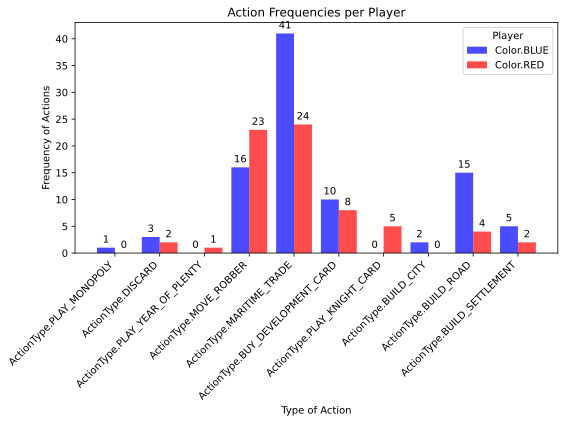

In [53]:
_, _ = plot_action_freqs(
    game.state.actions,
    exclusions=[ActionType.ROLL, ActionType.END_TURN]
)

MCTS Sims 2 | Playing 1/1 game
MCTS Sims 6 | Playing 1/1 game
MCTS Sims 10 | Playing 1/1 game


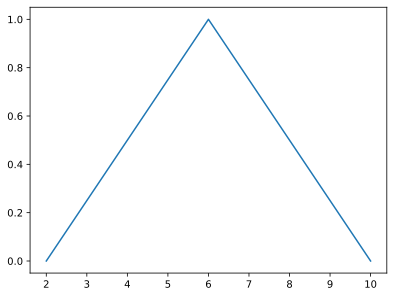

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

mcts_color: Color = Color.BLUE
sim_range=np.arange(2, 12, 4)
games_per_sim=1
n_playouts = len(sim_range)
mcts_win_rates = np.zeros(n_playouts)

for node_id, n_sim in enumerate(sim_range):
    mcts_playout_wins = 0
    for n_game_in_sim in range(1, games_per_sim + 1):
        print(f'MCTS Sims {n_sim} | Playing {n_game_in_sim}/{games_per_sim} game')
        game = Game(
            players=[
                RandomPlayer(color=Color.RED, is_bot=True),
                MCTSBot(color=Color.BLUE, n_simulations=n_sim),
            ]
        )
        winner_color = game.play()

        if winner_color == mcts_color:
            mcts_playout_wins += 1

    mcts_win_rates[node_id] = mcts_playout_wins / games_per_sim

plt.plot(sim_range, mcts_win_rates)
plt.show()

In [72]:
import numpy as np


for a in np.arange(2, 12, 4):
    print(a)

2
6
10


In [54]:
from catan.analysis.player_stats import player_stats, print_player_stats


stats = player_stats(game)
print_player_stats(stats)

[PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=8,
             settlements=[15, 26, 28],
             n_settlements=3,
             roads=[(2, 3), (7, 8), (2, 9), (3, 4), (4, 15), (15, 17), (17, 39),
                    (38, 39), (37, 38), (14, 15), (8, 27), (26, 27), (27, 28),
                    (1, 2), (13, 14)],
             n_roads=15,
             cities=[7, 3],
             n_cities=2),
 PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=5,
             longest_road=2,
             settlements=[19, 13],
             n_settlements=2,
             roads=[(19, 20), (12, 13), (0, 20), (13, 34)],
             n_roads=4,
             cities=[],
             n_cities=0)]


### MCTS Debug

### MCTS optimization

Our current MCTS scheme performance suffers, this is primarily by high branching factor -- actions possible with every step. According to thew previous analysis the average.

#### Potential moves that can be reduced

1. Initial settlement and road building, since there are 54 possible placement, we can limit only to the most promising ones.
2. Thief placement, instead of all possible tiles, place thief only on the most harmful fields for the opponents.
3. Die rolls and turn ends could be fast forwarded, no need to simulate the whole game.
4. 

In [1]:
def debug_mcts(root: MCTSNode):
    # print(root.untried_actions)
    print(root.untried_actions)
    

debug_game = Game(
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(
            color=Color.BLUE,
            n_simulations=10,
            # debug=True,
            debug_cb=debug_mcts
        ),
    ]
)
debug_game.play()

NameError: name 'MCTSNode' is not defined

In [367]:
from collections import Counter
from typing import Dict, List
from scipy.optimize import linear_sum_assignment
from catan.core.models.enums import BRICK, RESOURCES, WOOD, FastResource
from catan.core.models.map import NodeId
import itertools



def best_starting_tiles(node_prod: Dict[NodeId, Counter], owned_resources: List[FastResource] = []) -> List[NodeId]:
    val_matrix = np.zeros((len(node_prod), 5))
    
    cap_prods = list(node_prod.items())

    for (node_id, cntr) in cap_prods:
        for (rsrc_key, prob) in cntr.items():
            col_idx = RESOURCES.index(rsrc_key)
            
            if (rsrc_key in owned_resources):
                prob *= 0.2
            
            val_matrix[node_id][col_idx] = prob

    optimal_prod_idcs, _ = linear_sum_assignment(val_matrix, maximize=True)

    return list(optimal_prod_idcs)
            

# idxs = best_starting_tiles(map.node_production)

# for i in idxs:
#     print(map.node_production[i])

[n[0] for n in filter(lambda x: len(x[1]) > 2, map.node_production.items())]

[3, 4, 6, 8, 9, 11, 14, 15, 22]